In [271]:
import gzip
import json
import glob
import random
import tensorflow as tf
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from reddit.models import BatchTransformerForContextMLM
from transformers import TFDistilBertForMaskedLM, DistilBertTokenizer
from reddit.utils import load_tfrecord, mask_and_stack_mlm

In [272]:
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

In [273]:
pattern_1 = '../logs/mlm/10context_biencoder_3_1_attention/*/metrics/*/mlm/*/log.json'
fs = glob.glob(pattern_1) #+ glob.glob(pattern_2) #+ glob.glob(pattern_3) 

In [274]:
epochs = [f'epoch-{i}' for i in range(6)]
colors = dict(zip(epochs, ['darkgrey', 'grey', 'lightblue', 'darkblue', 'midnightblue', 'black']))
ls = {'author': '-', 'random':'--', 'subreddit':'dotted'}

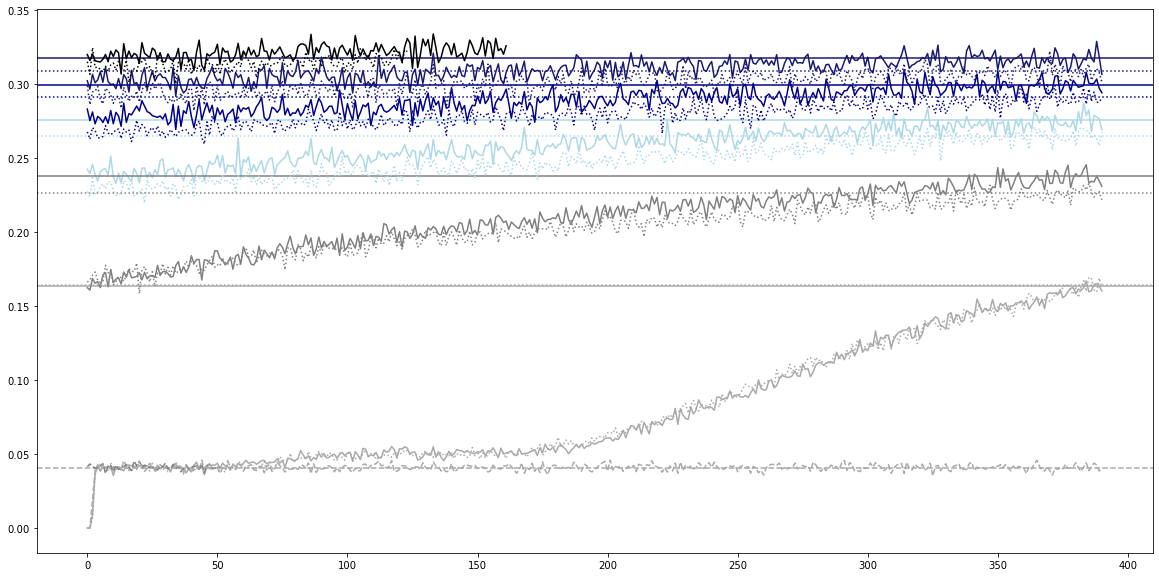

In [275]:
import warnings

warnings.filterwarnings('ignore')
c = 0

fg, ax = plt.subplots(figsize=(20,10))
for idx, f in enumerate(fs):
    d = json.load(open(f))
    if len(d['losses']) > 30:
        avg_loss = np.nanmean(d['test_losses'])
        avg_entropy = np.nanmean(d['test_entropy'])
        avg_true = np.nanmean(d['test_is_true_top'])
        # Get ds of test metrics
        sd_loss = np.nanstd(d['test_losses'])
        sd_entropy = np.nanstd(d['test_entropy'])
        sd_true = np.nanstd(d['is_true_top'])
        # Get other metrics with rolling average
        loss = np.nanmean(d['losses'])
        entropy  = np.nanmean(d['entropy'])
        true = np.nanmean(d['is_true_top'])
        grouping = f.split('/')[4]
        epoch = f.split('/')[-2]

        dict_log = {'epoch':[epoch], 
                    'grouping': [grouping],
                     'test_loss': [avg_loss],
                     'test_entropy': [avg_entropy],
                     'test_true': [avg_true],
                     'test_sd_loss': [sd_loss],
                     'test_sd_entropy': [sd_entropy],
                     'test_sd_true': [sd_true],
                     'loss': [loss],
                     'entropy': [entropy],
                     'true': [true],
                     'model_id': f.split('/')[-4],
                     'folder': f.split('/')[3]}

        sns.lineplot(x=range(len(np.arange(0, 1000000, 2000))), 
                     y=[np.mean(d['is_true_top'][i:i+2000]) for i in np.arange(0, 1000000, 2000)],
                     label='_'.join([f.split('/')[4], f.split('/')[-4]]),
                     c= colors[epoch], linestyle=ls[grouping], legend=False)
        plt.axhline(y=avg_true, c=colors[epoch], linestyle=ls[grouping])

        df = pd.DataFrame(dict_log)
        if c == 0:
            adf = df 
        else:
            adf = pd.concat([adf, df], ignore_index=True, sort=True)
        c+=1
    

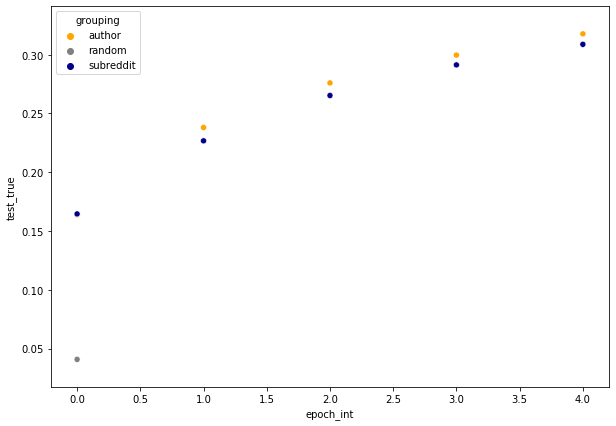

In [276]:
adf['epoch_int'] = adf['epoch'].str.split('-').str[1].astype(int)
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=adf, x='epoch_int', y='test_true', hue='grouping', palette=['orange','grey','darkblue'])